In [1]:
import sys
sys.path.insert(0, '../util')
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
from sc import *
from plot import *
from tqdm import tqdm
from alg import hstar, k_rollout, bhattacharya
from pqdict import pqdict
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from itertools import combinations
from copy import deepcopy

In [15]:
def plot_node_proj_diffs(SC, visit_order, proj, ref_path, path, vmin, vmax, fname, cmap=plt.cm.plasma, figsize=(6,6), s=20, path_color="red", linewidth=2, alpha=1):
    ref_proj = ref_path.proj
    proj_dict = {x:(SC.nodes[x], np.round(np.linalg.norm(proj[x]-ref_proj, 2), 5)) for x in proj}
    end = ref_path[-1]
    unwanted_nodes = visit_order[visit_order.index(end)+1:]

    xs = np.array([SC.nodes[i] for i in (np.where(SC.node_vec == 1)[0]) if i not in unwanted_nodes])
    node_pos = {i:SC.nodes[i] for i in (np.where(SC.node_vec == 1)[0]) if i not in unwanted_nodes}
    node_proj_diff = [proj_dict[i][1] for i in (np.where(SC.node_vec == 1)[0]) if i not in unwanted_nodes]

    G = deepcopy(SC.G)
    G.remove_nodes_from(unwanted_nodes)
    fig, ax = plt.subplots(1,1, figsize=figsize)

    for j, face in enumerate(SC.faces):
        if SC.face_vec[j]:
            continue
        color = 'darkgray'
        n1, n2, n3 = face
        tri = np.vstack([SC.nodes[n1], SC.nodes[n2], SC.nodes[n3]])
        ti = plt.Polygon(tri, color=color, alpha=1)
        ax.add_patch(ti)


    for edge in path.edges:
        n1, n2 = edge
        x1, y1 = SC.nodes[n1]
        x2, y2 = SC.nodes[n2]
        dx, dy = x2 - x1, y2 - y1
        ax.arrow(x1, y1, dx, dy, color=path_color, width=linewidth, length_includes_head=True)

    nx.draw(G, ax=ax, pos=node_pos, node_color=node_proj_diff, node_size=0, edge_color='grey', cmap=cmap)
    colors = [cmap(x/vmax) for x in node_proj_diff]
    ax.scatter(xs[:,0], xs[:,1], color=colors, s=s)
    if len(unwanted_nodes) > 0:
        xs_unwated = np.array([SC.nodes[i] for i in (np.where(SC.node_vec == 1)[0]) if i in unwanted_nodes])
        ax.scatter(xs_unwated[:,0], xs_unwated[:,1], color='k', s=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, fraction=0.033, pad=0)
    plt.savefig(fname, dpi=1000, pad_inches=0.2, bbox_inches='tight')

<AxesSubplot:>

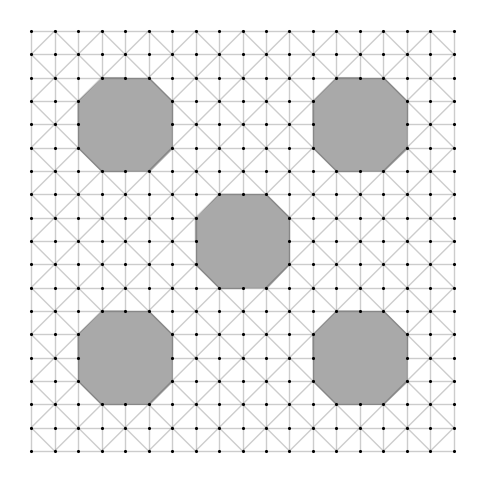

In [3]:
n = 19
# Initialize Simplicial Complex (SC)
SC2 = SimplicialComplex(n, False, False)
start, end = 0, len(SC2.node_vec)-1

hole_locs = np.array([[-0.55, -0.55], [-0.55, 0.55], [0.55, 0.55], [0.55, -0.55]])
SC2.make_holes(hole_locs, 0.2, np.inf)
SC2.make_holes([[0,0]], 0.22, np.inf)
plot_sc(SC2)

In [4]:
coords = np.array([(-1,-1), (1,-1), (1,0.1), (-1,0.1), (-1,1), (1,1)])
ref_path = path_from_coords(SC2, coords)
ref_proj = ref_path.proj

In [7]:
paths, visit_orders, projs = [], [], []
alphas = [0,0.5,1.5,2.5, 5, 7]

vmin, vmax = np.inf, 0
for i, alpha in enumerate(alphas):
    path, _, prev, visit_order_full, other_paths, proj = hstar(SC2, start, end, ref_proj, alpha, False, True, True)
    visit_order =[x[0] for x in visit_order_full]
    proj_vals = np.array([np.linalg.norm(proj[x] - ref_proj) for (i,x) in enumerate(proj) if SC2.node_vec[i] != 0])
    currmin = np.min(proj_vals)
    currmax = np.max(proj_vals)
    vmin = vmin if vmin < currmin else currmin
    vmax = vmax if vmax > currmax else currmax
    print(alpha, np.round(path.proj - ref_path.proj, 3), path.weight, visit_order.index(path[-1]))
    paths.append(path)
    visit_orders.append(visit_order)
    projs.append(proj)

    unwanted_nodes = visit_order[visit_order.index(end)+1:]
    other_paths_trunc = [x for x in other_paths if x.nodes[-1] not in unwanted_nodes]

0 [-0.312 -2.505 -0.626 -1.102  0.81 ] 3.0236892706218246 315
0.5 [ 0.066 -1.921 -1.411 -0.203 -0.174] 3.2189514164974597 315
1.5 [ 0.066 -1.921 -1.411 -0.203 -0.174] 3.21895141649746 315
2.5 [-0.  0.  0. -0.  0.] 6.291935221996614 187
5 [-0.  0.  0. -0.  0.] 6.606204902523967 86
7 [-0.  0.  0. -0.  0.] 6.606204902523967 63


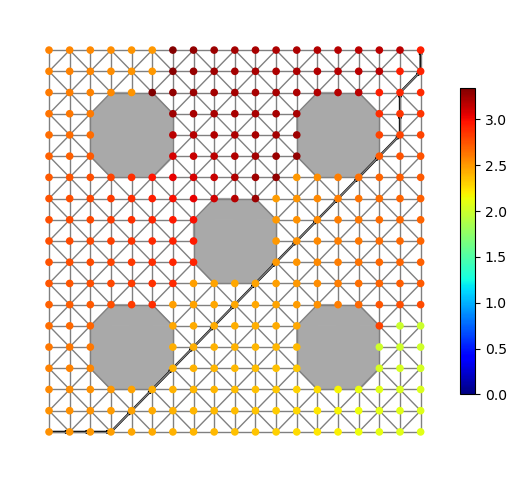

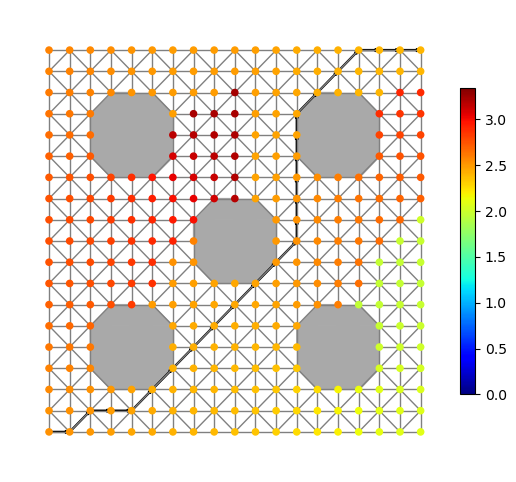

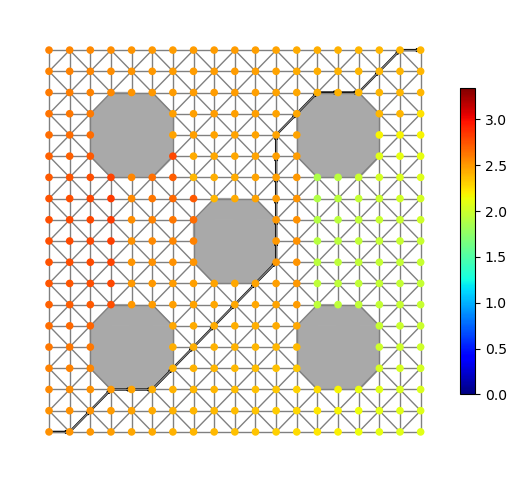

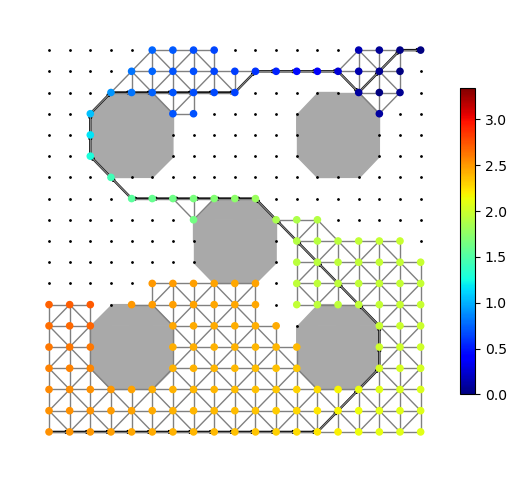

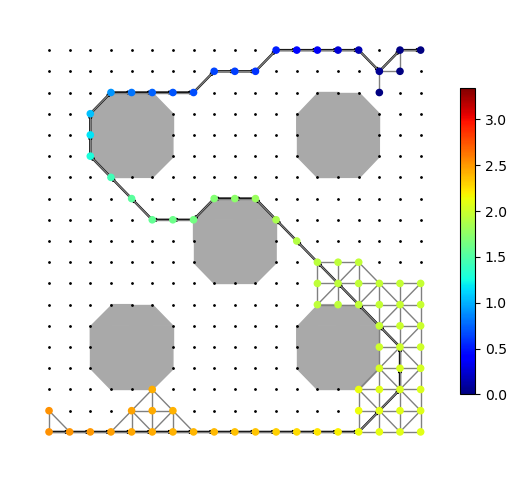

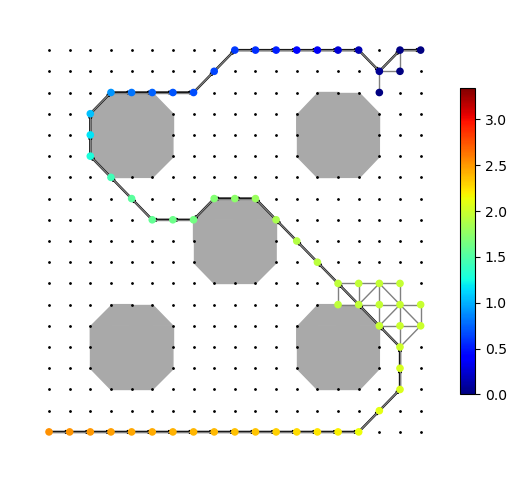

In [16]:
folder = "../exp3_data"

for i in range(len(alphas)):
    cmap=plt.cm.jet
    plot_node_proj_diffs(SC2, visit_orders[i], projs[i], ref_path, paths[i], vmin, vmax, f"{folder}/node_proj_diffs{i}.png", cmap, (6,6), 20, 'k', 0.005, 0.5)